# Baseline Gender Bias Document Classifiers

* **Supervised learning**
    * Train, Validate, and (Blind) Test Data: under directory `clf_data/`
* **Multilabel classification**
    * 3 categories of labels:
        1. *Person Name:* Unknown, Non-binary, Feminine, Masculine
        2. *Linguistic:* Generalization, Gendered Pronoun, Gendered Role
        3. *Contextual:* Empowering, Occupation, Omission, Stereotype

***

**Table of Contents**

[Setup](#set)

Baseline Classifiers:

  * [Classifier 1: Multinomial Naive Bayes](#mnb)

  * [Classifier 2: Logistic Regression](#log) - top-performing

  * [Classifier 3: Random Forest](#ran) - worst-performing
  
[Error Analysis](#err)

***

<a id="set"></a>
## Setup

In [1]:
# For custom functions
import utils

# For working with data files and directories
import numpy as np
import pandas as pd
from pathlib import Path

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For classification with scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_text
# from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

Read in the training, validation, (a.k.a. development or devtest) and blind test data:

In [2]:
datadir = "clf_data/"
X_train_path = datadir+"train_docs.txt"
X_devtest_path = datadir+"validate_docs.txt"
# X_blindtest_path = datadir+"blindtest_docs.txt"
y_train_path = datadir+"train_labels.txt"
y_devtest_path = datadir+"validate_labels.txt"
# y_blindtest_path = datadir+"blindtest_labels.txt"

In [3]:
docs_seperator = "\n|\n"
labels_seperator = "\n"

In [5]:
X_train = utils.readData(X_train_path, docs_seperator)
print(X_train[0])
assert len(X_train) == 7044, "The length of the training data should be the same as the number of rows of the train DataFrame (see SplitData.ipynb)"

This paper was published as a chapter in A Companion to Genethics, ed. J. Burley and J. Harris (Wiley-Blackwell, 2002).


In [6]:
X_devtest = utils.readData(X_devtest_path, docs_seperator)
print(X_devtest[0])
assert len(X_devtest) == 2350, "The length of the validation data should be the same as the number of rows of the dev DataFrame (see SplitData.ipynb)"

Peter Baillie ( 1889-1914), youngest brother to John Baillie and Donald Macpherson Baillie, was educated at Inverness Royal Academy and then at George Watson's College. Entering Edinburgh University in 1907, he graduated with a M.B., Ch.B. in 1912. For many years he was a member of the Philomathic Society and became its President in 1911. He was senior house surgeon at Mildmay Mission Hospital, London, for six months and in January 1914 he left Britain for Jalna, India, taking up a post to which he had been appointed by the Foreign Mission Committee of the United Free Church. He was ordained as a missionary elder of Langside Hill United Free Church, Glasgow, prior to his departure. While in India he was the victim of a drowning at Mahableshwar.


In [7]:
y_train = utils.readData(y_train_path, labels_seperator)
print(y_train[:3])
assert len(y_train) == 7044, "The length of the training data should be the same as the number of rows of the train DataFrame (see SplitData.ipynb)"

['Occupation, Unknown' 'Occupation, Unknown' 'Unknown']


In [9]:
y_devtest = utils.readData(y_devtest_path, labels_seperator)
print(y_devtest[0])
assert len(X_devtest) == 2350, "The length of the validation data should be the same as the number of rows of the dev DataFrame (see SplitData.ipynb)"

Generalization, Gendered-Role, Unknown, Masculine, Occupation, Gendered-Pronoun


In [8]:
# X_blindtest = utils.readData(X_blindtest_path, docs_seperator)
# y_blindtest = utils.readData(y_blindtest_path, labels_seperator)
# assert len(X_blindtest) == len(y_blindtest), "There should be one group of labels for every document."

Convert the data to numeric representations, where:
```
labels = {
    "Unknown": 0, "Non-binary": 1, "Feminine": 2, "Masculine": 3,
    "Generalization": 4, "Gendered-Pronoun": 5, "Gendered-Role": 6,
    "Occupation": 7, "Omission":8, "Stereotype": 9, "Empowering": 10
         }
```

In [11]:
# Convert the strings of labels to tuples of numbers
y_train_numeric = utils.getNumericLabels(y_train)
y_devtest_numeric = utils.getNumericLabels(y_devtest)
# y_blindtest_numeric = utils.getNumericLabels(y_blindtest)
assert len(y_train_numeric) == len(y_train)
assert len(y_devtest_numeric) == len(y_devtest)
# assert len(y_blindtest_numeric) == len(y_blindtest)

Binarize the data so labels are represented by a 0 (not present) or 1 (present):

In [13]:
# Convert each iterable of iterables above to a multilabel format
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train_numeric)
y_devtest_binarized = mlb.fit_transform(y_devtest_numeric)
# y_blindtest_binarized = mlb.fit_transform(y_blindtest_numeric)
print(y_devtest_binarized.shape)
print(y_devtest_binarized[0])

(2350, 9)
[1 0 1 1 1 1 1 0 0]


In [ ]:
# # Bag of Words
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# X_test_counts = count_vect.fit_transform(X_test)
# print("Bag of Words:")
# print(X_train_counts.shape)
# print(X_test_counts.shape)

# # Term Frequency times Inverse Document Frequency
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
# print("TFIDF:")
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)

In [ ]:
# assert X_train_counts.shape[0] == len(y_train_numeric)
# assert X_test_tfidf.shape[0] == len(y_test_numeric)

Create the directory to write the classification models' performance metrics to:

In [14]:
metrics_dir = "./baseline_performance_metrics/"
Path(metrics_dir).mkdir(parents=True, exist_ok=True)

## Baseline Classifiers
<a id="mnb"></a>
### Classifier 1: Multinomial Naive Bayes

Build a pipeline:

In [15]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(MultinomialNB()))
    ])

In [16]:
clf_pipeline.fit(X_train, y_train_binarized)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0,
                                                             class_prior=None,
  

In [19]:
predicted_dev = clf_pipeline.predict(X_devtest)
# predicted_test = clf_pipeline.predict(X_blindtest)

### Peformance

Calculate performance metrics for the Multinomial Naive Bayes classifier

In [21]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))
# print("Blind Test Accuracy:", np.mean(predicted_test == y_blindtest_binarized))

Dev Test Accuracy: 0.8754137115839243


In [22]:
classes = clf_pipeline.classes_
print(classes)
original_classes = mlb.classes_
print(original_classes)

[0 1 2 3 4 5 6 7 8]
[0 2 3 4 5 6 7 8 9]


Plot a [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-confusion-matrix) of the results, where, for class *i*:
* Count of true negatives (TN) is at position *i*,0,0
* Count of false negatives (FN) is at position *i*,1,0
* Count of true positives (FP) is at position *i*,1,1
* Count of false positives (PF) is at position *i*,0,1

In [23]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,235,37,1735,343,0.834937,0.979120,0.901299
1,Feminine,2236,113,1,0,1.000000,0.008772,0.017391
2,Masculine,1782,232,300,36,0.892857,0.563910,0.691244
3,Generalization,2080,270,0,0,0.000000,0.000000,0.000000
4,Gendered-Pronoun,2107,234,7,2,0.777778,0.029046,0.056000
5,Gendered-Role,1963,375,12,0,1.000000,0.031008,0.060150
6,Occupation,1977,352,21,0,1.000000,0.056300,0.106599
7,Omission,1465,305,448,132,0.772414,0.594954,0.672168
8,Stereotype,2054,202,92,2,0.978723,0.312925,0.474227


In [24]:
# test_matrix = multilabel_confusion_matrix(y_blindtest_binarized, predicted_test, labels=classes)
# df_test = utils.getPerformanceMetrics(y_blindtest_binarized, predicted_test, test_matrix, classes, original_classes)
# df_test

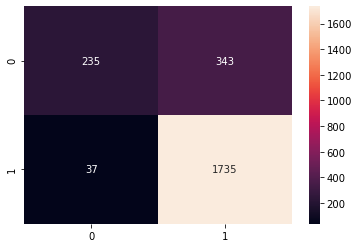

In [25]:
ax = sns.heatmap(dev_matrix[0], annot=True, fmt="d")

In [ ]:
# ax = sns.heatmap(test_matrix[0], annot=True, fmt="d")

In [26]:
df_dev.to_csv(metrics_dir+"MultinomialNB_dev_performance.csv")
# df_test.to_csv(metrics_dir+"MultinomialNB_test_performance.csv")

<a id="log"></a>
### Classifier 2: Logistic Regression

*a.k.a. maximum-entropy (MaxEnt) or log-linear classification*

In [52]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(LogisticRegression(solver="liblinear", multi_class="ovr")))
    ])

In [53]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)
# predicted_test = clf_pipeline.predict(X_blindtest)

### Performance

Calculate performance metrics for the Logistic Regression classifier

In [54]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))
# print("Blind Test Accuracy:", np.mean(predicted_test == y_blindtest_binarized))

Dev Test Accuracy: 0.9106855791962175


In [55]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_

In [56]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
# test_matrix = multilabel_confusion_matrix(y_blindtest_binarized, predicted_test, labels=classes)

In [57]:
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,267,43,1729,311,0.847549,0.975734,0.907135
1,Feminine,2233,89,25,3,0.892857,0.219298,0.352113
2,Masculine,1767,132,400,51,0.886918,0.751880,0.813835
3,Generalization,2059,158,112,21,0.842105,0.414815,0.555831
4,Gendered-Pronoun,2100,101,140,9,0.939597,0.580913,0.717949
5,Gendered-Role,1946,191,196,17,0.920188,0.506460,0.653333
6,Occupation,1959,235,138,18,0.884615,0.369973,0.521739
7,Omission,1479,276,477,118,0.801681,0.633466,0.707715
8,Stereotype,2029,89,205,27,0.883621,0.697279,0.779468


In [51]:
# df_test = utils.getPerformanceMetrics(y_blindtest_binarized, predicted_test, test_matrix, classes, original_classes)
# df_test

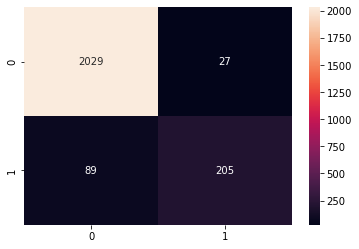

In [58]:
ax = sns.heatmap(dev_matrix[8], annot=True, fmt="d")

In [ ]:
# ax = sns.heatmap(test_matrix[0], annot=True, fmt="d")

This classifier performs better than the first classifier (Multinomial Naive Bayes) and third classifier (Random Forest).

In [34]:
df_dev.to_csv(metrics_dir+"LogisticRegression_dev_performance.csv")
# df_test.to_csv(metrics_dir+"LogisticRegression_test_performance.csv")

<a id="ran"></a>
### Classifier 3: Random Forest

In [35]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(RandomForestClassifier(max_depth=3, random_state=0)))
    ])

In [37]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)
# predicted_test = clf_pipeline.predict(X_blindtest)

In [38]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_

In [39]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))
# print("Blind Test Accuracy:", np.mean(predicted_test == y_blindtest_binarized))

Dev Test Accuracy: 0.8332860520094563


In [40]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,0,0,1772,578,0.754043,1.000000,0.859777
1,Feminine,2236,114,0,0,0.000000,0.000000,0.000000
2,Masculine,1817,525,7,1,0.875000,0.013158,0.025926
3,Generalization,2080,270,0,0,0.000000,0.000000,0.000000
4,Gendered-Pronoun,2109,239,2,0,1.000000,0.008299,0.016461
5,Gendered-Role,1963,387,0,0,0.000000,0.000000,0.000000
6,Occupation,1977,371,2,0,1.000000,0.005362,0.010667
7,Omission,1596,746,7,1,0.875000,0.009296,0.018397
8,Stereotype,2056,294,0,0,0.000000,0.000000,0.000000


In [43]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)

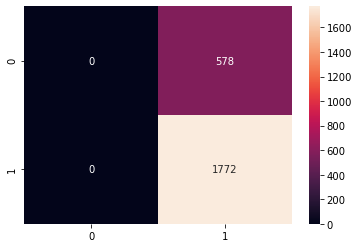

In [44]:
ax = sns.heatmap(dev_matrix[0], annot=True, fmt="d")

In [41]:
# test_matrix = multilabel_confusion_matrix(y_blindtest_binarized, predicted_test, labels=classes)
# df_test = utils.getPerformanceMetrics(y_blindtest_binarized, predicted_test, test_matrix, classes, original_classes)
# df_test

This classifier performs worse than the other two.

In [42]:
df_dev.to_csv(metrics_dir+"RandomForest_dev_performance.csv")
# df_test.to_csv(metrics_dir+"RandomForest_test_performance.csv")

<a id="err"></a>
## Error Analysis

Error analysis of the **Logistic Regression** classifier, as this is the top-performing baseline classification model.

In [ ]:
# Associate classes to numeric labels to strings of label names
label_class_to_no = dict(zip(classes,original_classes))
labels = {
    "Unknown": 0, "Non-binary": 1, "Feminine": 2, "Masculine": 3,
    "Generalization": 4, "Gendered-Pronoun": 5, "Gendered-Role": 6,
    "Occupation": 7, "Omission":8, "Stereotype": 9, "Empowering": 10
         }
label_no_to_name = dict(zip(list(labels.values()), list(labels.keys())))

#### Dev Test Data Confusion Matrices

In [ ]:
matrices = dict()  # keys are labels, values are 2D arrays 
for col in range(len(classes)):
    y_test_label = y_devtest_binarized[:, col]
    pred_label = predicted_dev[:, col]
    
    matrices[classes[col]] = confusion_matrix(pred_label, y_test_label, normalize="all")

In [ ]:
png_dir = metrics_dir+"logreg_dev_confusion_matrices/"
Path(png_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
for label_class,matrix in matrices.items():
    label_name = label_no_to_name[label_class_to_no[label_class]]
    filename = "{}_cmatrix_normalized_all.png".format(label_name)
    ConfusionMatrixDisplay(matrix, display_labels=["Not "+label_name,label_name]).plot()
    plt.savefig(png_dir+filename)

#### Blind Test Data Confusion Matrices

In [ ]:
matrices = dict()  # keys are labels, values are 2D arrays 
for col in range(len(classes)):
    y_test_label = y_blindtest_binarized[:, col]
    pred_label = predicted_test[:, col]
    
    matrices[classes[col]] = confusion_matrix(pred_label, y_test_label, normalize="all")

In [ ]:
png_dir = metrics_dir+"logreg_test_confusion_matrices/"
Path(png_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
for label_class,matrix in matrices.items():
    label_name = label_no_to_name[label_class_to_no[label_class]]
    filename = "{}_cmatrix_normalized_all.png".format(label_name)
    ConfusionMatrixDisplay(matrix, display_labels=["Not "+label_name,label_name]).plot()
    plt.savefig(png_dir+filename)

For all labels except `Unknown`, for which the true positive rate is high, the true negative rates are high but the true positive, false positive, and false negative rates are very low.

In [ ]:
y_devtest_binarized

In [ ]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_
print("Clf Classes:", classes)
print("Original Classes:", original_classes)